In [74]:
import numpy as np
import openseespy.opensees as ops
import matplotlib.pyplot as plt

import opstool as opst


In [75]:
UNIT = opst.pre.UnitSystem(length="m", force="kn", time="sec")
analysis = opst.anlys.SmartAnalyze('Static')

🚀 OPSTOOL::SmartAnalyze:   0%|          | 0/2600 [00:28<?, ? step/s]


In [76]:
ops.wipe()
ops.model("basic", "-ndm", 1, "-ndf", 1)

# 编号
matTag = 100
# 基本参数
fy = 309.57 * UNIT.mpa
fu = 476.9 * UNIT.mpa
Es = 176.7 * UNIT.gpa
Esh = 0.01 * Es
esh = 1.5 * (fy / Es)
eult  = 0.1

# 间隙材料
# ops.uniaxialMaterial("HookGap", matTag, Es, -0.05, 0.05)

# 屈曲参数
GABuck_lsr = 6.0
GABuck_beta = 1.0
GABuck_r = 0.0
GABuck_gamma = 0.5
# 钢筋屈曲材料
# ops.uniaxialMaterial(
#     'ReinforcingSteel', matTag, fy, fu, Es, Esh, esh, eult,
#     '-GABuck', GABuck_lsr, GABuck_beta, GABuck_r, GABuck_gamma)

# 仅受压材料
# ops.uniaxialMaterial("ENT", matTag, -Es)
# ops.uniaxialMaterial("ENT", matTag, Es)

# 间隙弹性材料
# ops.uniaxialMaterial("ElasticPPGap", matTag, Es, 1.e10, 0.05)
# ops.uniaxialMaterial("ElasticPPGap", matTag, Es, -fy, -0.05)

# 串联 - 并联材料
ops.uniaxialMaterial('Elastic', 1, 1.28e4)
ops.uniaxialMaterial('Elastic', 2, Es)
ops.uniaxialMaterial('Series', 3, 1, 2)

fy = 1.e10
ops.uniaxialMaterial("ElasticPPGap", 4, Es, fy, 0.05)
ops.uniaxialMaterial("ElasticPPGap", 5, Es, -fy, -0.05)

ops.uniaxialMaterial("ElasticPPGap", 6, 1.28e8, fy, 1.e-10)
ops.uniaxialMaterial("ElasticPPGap", 7, 1.28e4, -fy, -1.e-10)

# ops.uniaxialMaterial('Parallel', matTag, 3, 4, 5)
# ops.uniaxialMaterial('Parallel', matTag, 1, 4, 5)
ops.uniaxialMaterial('Parallel', matTag, 4, 5, 6, 7)

In [77]:
tar = [
    0.,
    0.02, -0.02,
    0.04, -0.04,
    0.06, -0.06,
    0.08, -0.08,
    0.10, -0.10,
    0.15, -0.15,
    0.20, -0.20,
    0.
    ]
segs = analysis.static_split(targets=tar, maxStep=0.001) # 每一步分割
disp_pattern = np.insert(np.cumsum(segs), 0, tar[0]) # 累计

🚀 OPSTOOL::SmartAnalyze:   0%|          | 0/2600 [00:00<?, ? step/s]

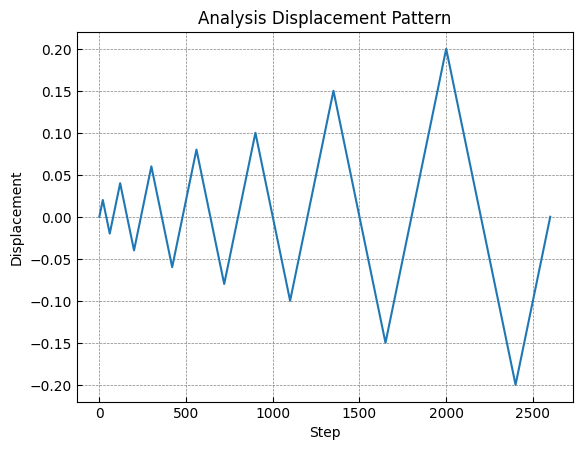

In [78]:
plt.close('all')
plt.title('Analysis Displacement Pattern')
plt.plot(disp_pattern, label='Displacement')
plt.xlabel('Step')
plt.ylabel('Displacement')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [79]:
stress = []
strain = []
# test material
ops.testUniaxialMaterial(matTag)
for disp in disp_pattern:
    ops.setStrain(disp)
    stress.append(ops.getStress())
    strain.append(ops.getStrain())

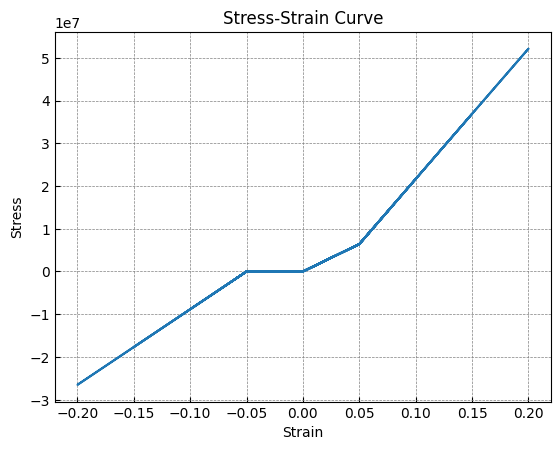

In [80]:
plt.close('all')
plt.title('Stress-Strain Curve')
plt.plot(strain, stress)
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()